In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import transformers, datasets
transformers.utils.logging.set_verbosity_error()
datasets.utils.logging.set_verbosity_error()

/Users/q_user/miniforge3/envs/ZR/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Nonparametric quantification of uncertainty of text classification models using conformal prediction

## Dataset

### Loading

In [3]:
from datasets import load_dataset
import numpy as np
dataset = load_dataset('amazon_polarity')
smaller_dataset = load_dataset('amazon_polarity')
smaller_dataset["calib"] = smaller_dataset["train"].filter(lambda e, i: i>=20000 and i<30000, with_indices=True)
smaller_dataset["train"] = smaller_dataset["train"].filter(lambda e, i: i<20000, with_indices=True)
smaller_dataset["test"] = smaller_dataset["test"].filter(lambda e, i: i<10000, with_indices=True)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 81.79it/s]


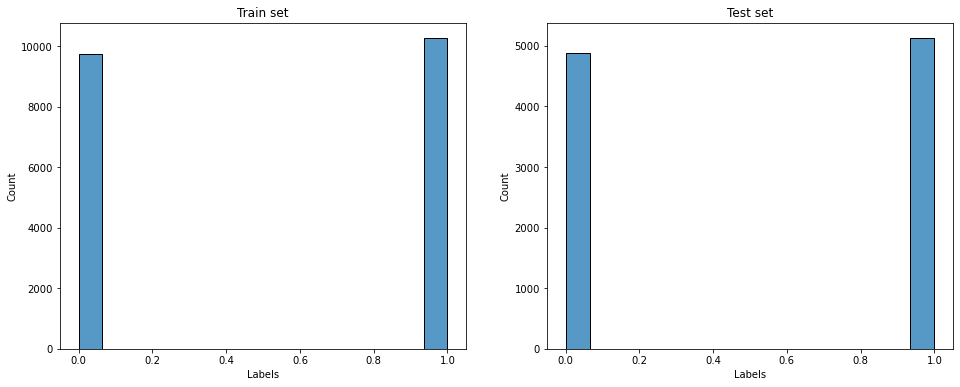

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(smaller_dataset["train"]["label"], ax=ax[0])
sns.histplot(smaller_dataset["test"]["label"], ax=ax[1])
ax[0].set_xlabel('Labels'); ax[1].set_xlabel('Labels');
ax[0].set_title('Train set'); ax[1].set_title('Test set');

### DistilBERT Tokenizer

In [5]:
from transformers import AutoTokenizer

tokenizer_distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function_distilbert(examples):
    return tokenizer_distilbert(examples["title"], truncation=True)

In [ ]:
tokenized_dataset_distilbert = dataset['test'].map(preprocess_function_distilbert, batched=True)
smaller_tokenized_dataset_distilbert = smaller_dataset.map(preprocess_function_distilbert, batched=True)

### RoBERTa Tokenizer

In [8]:
from transformers import AutoTokenizer

tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")
def preprocess_function_roberta(examples):
    return tokenizer_roberta(examples["title"], truncation=True)

In [ ]:
tokenized_dataset_roberta = dataset['test'].map(preprocess_function_roberta, batched=True)
smaller_tokenized_dataset_roberta = smaller_dataset.map(preprocess_function_roberta, batched=True)

## Model

### CountVectorizer & Logistic Regression

- na test setu predvidim 0 i 1 i nađem ngrame koji se najcesce pojavljuju u kojem setu
- word cloud n-grama za label 0 i 1 (postoji python lib)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

vectorizer = CountVectorizer()
logistic = LogisticRegression(max_iter=10000, tol=0.1)

pipe = Pipeline(steps=[("vectorizer", vectorizer), ("logistic", logistic)])

param_grid = {
    "vectorizer__lowercase": [False, True],
    "vectorizer__stop_words": [None, 'english'],
    "vectorizer__ngram_range": [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)],
    "vectorizer__max_features": [None, 100, 300],
    "logistic__C": np.logspace(-4, 4, 4),
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=1)
search.fit(smaller_dataset["train"]["title"], smaller_dataset["train"]["label"])
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [11]:
predicted_proba_cv_lr = search.best_estimator_.predict_proba(smaller_tokenized_dataset_distilbert["test"]["title"])

In [12]:
from scipy.special import softmax
data_cv_lr = predicted_proba_cv_lr[:,1], np.array(smaller_tokenized_dataset_distilbert["test"]["label"]), softmax(predicted_proba_cv_lr, axis=1)[:,1]

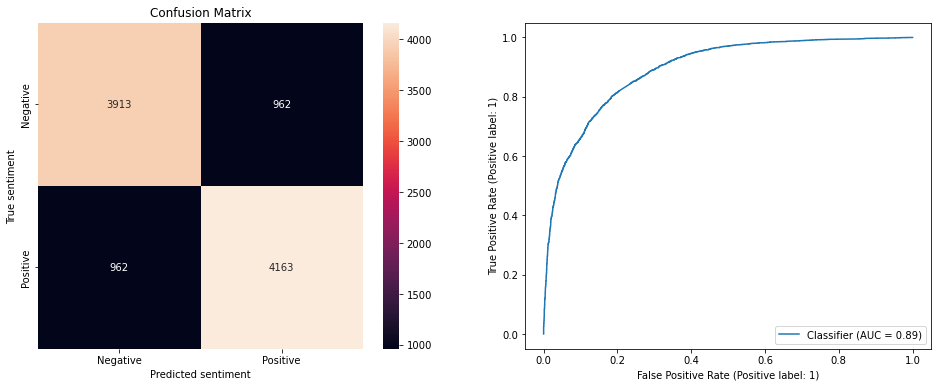

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

threshold = 0.5
y_hat_cv_lr = (data_cv_lr[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_cv_lr[1], y_hat_cv_lr), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted sentiment'); ax[0].set_ylabel('True sentiment')
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative', 'Positive']); ax[0].yaxis.set_ticklabels(['Negative', 'Positive'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_cv_lr[1], predicted_proba_cv_lr[:,1], ax=ax[1])

In [14]:
from sklearn.metrics import classification_report
print(classification_report(data_cv_lr[1], (data_cv_lr[0] > 0.5)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      4875
           1       0.81      0.81      0.81      5125

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



### DistilBERT

In [10]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_distilbert = DataCollatorWithPadding(tokenizer=tokenizer_distilbert)
def model_distilbert_init():
    return AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, return_dict=True)

In [ ]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args_distilbert = TrainingArguments(
    output_dir="./results_distilbert",
    num_train_epochs=10,
)

trainer_distilbert = Trainer(
    model_init=model_distilbert_init,
    args=training_args_distilbert,
    train_dataset=smaller_tokenized_dataset_distilbert["train"],
    eval_dataset=smaller_tokenized_dataset_distilbert["test"],
    tokenizer=tokenizer_distilbert,
    data_collator=data_collator_distilbert
)

trainer_distilbert.hyperparameter_search(
    direction="maximize", 
    backend="optuna", 
    n_trials=10 # number of trials
)

trainer_distilbert.train()

In [16]:
trainer_distilbert.save_model('distilbert')

Saving model checkpoint to distilbert
Configuration saved in distilbert/config.json
Model weights saved in distilbert/pytorch_model.bin
tokenizer config file saved in distilbert/tokenizer_config.json
Special tokens file saved in distilbert/special_tokens_map.json


**Load pretrained model**

In [11]:
from transformers import AutoModelForSequenceClassification
model_distilbert = AutoModelForSequenceClassification.from_pretrained('./distilbert/')

from transformers import TextClassificationPipeline
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_distilbert = DataCollatorWithPadding(tokenizer=tokenizer_distilbert)

trainer_distilbert = Trainer(
    model=model_distilbert,
    train_dataset=smaller_tokenized_dataset_distilbert["train"],
    eval_dataset=smaller_tokenized_dataset_distilbert["test"],
    tokenizer=tokenizer_distilbert,
    data_collator=data_collator_distilbert
)

**Predict**

In [12]:
import torch
import torch.nn.functional as F
predicted_distilbert = trainer_distilbert.predict(smaller_tokenized_dataset_distilbert["test"])

predicted_proba_distilbert = torch.tensor(predicted_distilbert.predictions)
predicted_softmax_distilbert = F.softmax(predicted_proba_distilbert, dim=1)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, title.
***** Running Prediction *****
  Num examples = 10000
  Batch size = 8


In [13]:
data_distilbert = predicted_proba_distilbert[:,1].numpy(), np.array(smaller_tokenized_dataset_distilbert["test"]["label"]), predicted_softmax_distilbert[:,1].numpy()

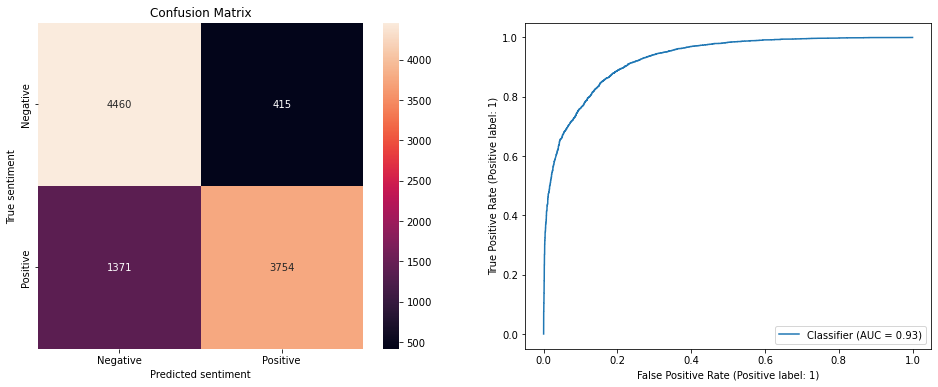

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt    
import seaborn as sns

threshold = 0.5
y_hat_distilbert = (data_distilbert[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_distilbert[1], y_hat_distilbert), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted sentiment'); ax[0].set_ylabel('True sentiment')
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative', 'Positive']); ax[0].yaxis.set_ticklabels(['Negative', 'Positive'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_distilbert[1], predicted_proba_distilbert[:,1], ax=ax[1])

In [15]:
from sklearn.metrics import classification_report
print(classification_report(data_distilbert[1], (data_distilbert[0] > 0.5)))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      4875
           1       0.90      0.73      0.81      5125

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



## Model

### RoBERTa

In [16]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_roberta = DataCollatorWithPadding(tokenizer=tokenizer_roberta)
def model_roberta_init():
    return AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2, return_dict=True)

In [ ]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args_roberta = TrainingArguments(
    output_dir="./results_roberta",
    num_train_epochs=10,
)

trainer_roberta = Trainer(
    model_init=model_roberta_init,
    args=training_args_roberta,
    train_dataset=smaller_tokenized_dataset_roberta["train"],
    eval_dataset=smaller_tokenized_dataset_roberta["test"],
    tokenizer=tokenizer_roberta,
    data_collator=data_collator_roberta
)

trainer_roberta.hyperparameter_search(
    direction="maximize", 
    backend="optuna", 
    n_trials=10 # number of trials
)

trainer_roberta.train()

In [18]:
trainer_roberta.save_model('roberta')

Saving model checkpoint to roberta
Configuration saved in roberta/config.json
Model weights saved in roberta/pytorch_model.bin
tokenizer config file saved in roberta/tokenizer_config.json
Special tokens file saved in roberta/special_tokens_map.json


**Load pretrained model**

In [ ]:
from transformers import AutoModelForSequenceClassification
model_roberta = AutoModelForSequenceClassification.from_pretrained('./roberta/')

from transformers import TextClassificationPipeline
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_roberta = DataCollatorWithPadding(tokenizer=tokenizer_roberta)

trainer_roberta = Trainer(
    model=model_roberta,
    train_dataset=smaller_tokenized_dataset_roberta["train"],
    eval_dataset=smaller_tokenized_dataset_roberta["test"],
    tokenizer=tokenizer_roberta,
    data_collator=data_collator_roberta
)

**Predict**

In [20]:
import torch
import torch.nn.functional as F
predicted_roberta = trainer_roberta.predict(smaller_tokenized_dataset_roberta["test"])

predicted_proba_roberta = torch.tensor(predicted_roberta.predictions)
predicted_softmax_roberta = F.softmax(predicted_proba_roberta, dim=1)

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: content, title.
***** Running Prediction *****
  Num examples = 10000
  Batch size = 8


In [21]:
data_roberta = predicted_proba_roberta[:,1].numpy(), np.array(smaller_tokenized_dataset_roberta["test"]["label"]), predicted_softmax_roberta[:,1].numpy()

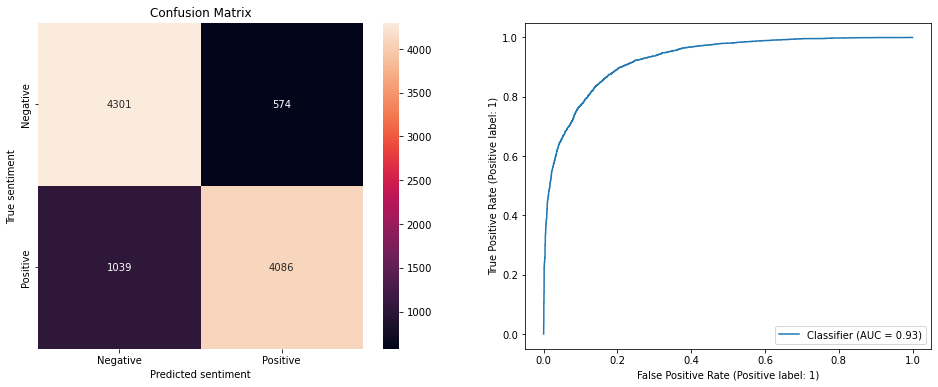

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

threshold = 0.5
y_hat_roberta = (data_roberta[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_roberta[1], y_hat_roberta), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted sentiment'); ax[0].set_ylabel('True sentiment')
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative', 'Positive']); ax[0].yaxis.set_ticklabels(['Negative', 'Positive'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_roberta[1], predicted_proba_roberta[:,1], ax=ax[1])

In [23]:
from sklearn.metrics import classification_report
print(classification_report(data_roberta[1], (data_roberta[0] > 0.5)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      4875
           1       0.88      0.80      0.84      5125

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## Evaluation - Permutation test

In [55]:
from tqdm import tqdm
import random
def permutation_test(y_hat_1, y_hat_2, y_true, score, n_eval=100000):
    D = abs(score(y_hat_1, y_true) - score(y_hat_2, y_true))
    counter = 0
    for i in tqdm(range(n_eval)):
        change = np.array([random.randint(0, 1) for x in range(len(y_true))])
        same = 1 - change
        
        y_hat_1_eval = same*y_hat_1 + change*y_hat_2
        y_hat_2_eval = same*y_hat_2 + change*y_hat_1
        
        if abs(score(y_hat_1_eval, y_true) - score(y_hat_2_eval, y_true)) >= D:
            counter += 1
    return counter / n_eval

In [56]:
from sklearn.metrics import f1_score
permutation_test((data_roberta[0] > 0.5), (data_distilbert[0] > threshold), np.array(smaller_tokenized_dataset_roberta["test"]["label"]), f1_score)

100%|██████████████████████████████████| 100000/100000 [03:27<00:00, 482.25it/s]


0.20577

## Evaluation - VennAbers

**Supporting code**

In [317]:
import VennAbers
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor, ceil, exp
from sklearn.calibration import CalibratedClassifierCV

def plot_all_score(data):
    rng = np.array(list(range(floor(data[0].min()*100), ceil(data[0].max()*100), 1))) / 100
    venn_abers = VennAbers.venn_abers_fast(list(zip(data[0], data[1])), rng)
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(rng)
    
    ps = CalibratedClassifierCV()
    ps.fit(data[0].reshape(-1, 1), data[1])
    platt_scaling = ps.predict_proba(rng.reshape(-1, 1))[:,1]
    
    plt.figure(figsize=(10,10))
    #sns.lineplot(x=rng, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(rng, venn_abers[0], venn_abers[1], color='orange', alpha=1)
    #sns.lineplot(x=rng, y=predicted_proba, linestyle='dotted')
    sns.lineplot(x=rng, y=platt_scaling)
    sns.lineplot(data[0], data[2], color='green', alpha=.65)
    plt.axis((floor(data[0].min()), ceil(data[0].max()), 0, 1))
    
    #xpoints = ypoints = plt.xlim()
    #plt.plot(xpoints, ypoints, linestyle='--', color='grey', lw=1, scalex=False, scaley=False)
    
    plt.xticks(np.arange(floor(data[0].min()), ceil(data[0].max())+0.1, step=0.5))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend(["Venn-Abers Interval", "Platt Scaling", "Softmax"])
    plt.xlabel('Score'); plt.ylabel('Calibrated probability')

### DistilBERT

/Users/q_user/miniforge3/envs/ZR/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


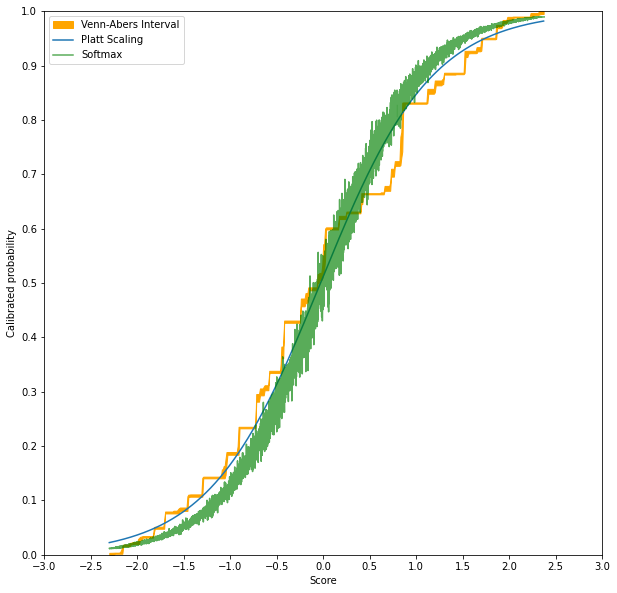

In [318]:
plot_all_score(data_distilbert)

### RoBERTa

/Users/q_user/miniforge3/envs/ZR/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


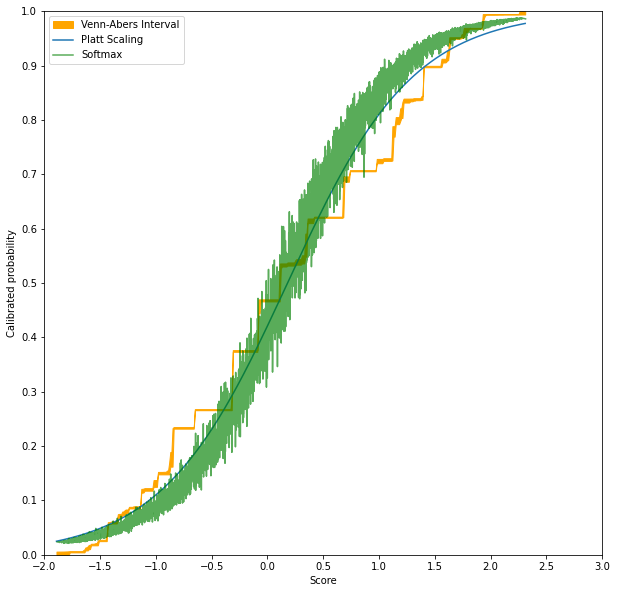

In [319]:
plot_all_score(data_roberta)

## Time evaluation

In [35]:
import time
import VennAbers
from tqdm import tqdm
data_time_eval = data_distilbert

In [38]:
def time_eval_slow(rounds=10):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        for s_x_test in (np.array(list(range(0, 101, 1))) / 100):
            venn_abers = VennAbers.venn_abers(list(zip(data_time_eval[0], data_time_eval[1])), s_x_test)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [39]:
def time_eval_fast(rounds=10):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        venn_abers = VennAbers.venn_abers_fast(list(zip(data_time_eval[0], data_time_eval[1])), np.array(list(range(0, 101, 1))) / 100)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [40]:
time_slow, time_fast = time_eval_slow(), time_eval_fast()
print(f"Slow Venn-Abers (avg. - 100 runs): {round(time_slow)} ms")
print(f"Fast Venn-Abers (avg. - 100 runs): {round(time_fast)} ms")
print(f"Average speed-up of {round((1/time_fast) / (1/time_slow), 1)}x (100 runs)")

Slow Venn-Abers (avg. - 100 runs): 172 ms
Fast Venn-Abers (avg. - 100 runs): 83 ms
Average speed-up of 2.1x (100 runs)


## Evaluation - Conformal

In [316]:
from tqdm import tqdm

def eval_conformal_prediction(prediction_sets, y):
    return sum([1 if y_i in y_i_hat else 0 for y_i, y_i_hat in zip(y, prediction_sets)]) / len(y_test)

def conformal_prediction(y_calib, y_hat_calib, y_hat_test, alpha=0.05):
    n = y_calib.shape[0]
    scores = 1 - torch.tensor([float(y[y_class]) for y, y_class in zip(y_hat_calib.softmax(dim=1), y_calib)])
    qhat = torch.quantile(scores, np.ceil((n+1)*(1-alpha))/n)
    smx = y_hat_test.softmax(dim=1)

    prediction_sets = []
    for y in (smx > (1-qhat)):
        y_i = []
        for y_c in range(2):
            if y[y_c]:
                y_i.append(y_c)
        prediction_sets.append(y_i)
    return prediction_sets

predicted_calib = trainer_distilbert.predict(smaller_tokenized_dataset_distilbert["calib"])
y_hat_calib = torch.tensor(predicted_calib.predictions)
y_calib = np.array(smaller_tokenized_dataset_distilbert["calib"]["label"])

predicted_test = trainer_distilbert.predict(smaller_tokenized_dataset_distilbert["test"])
y_hat_test = torch.tensor(predicted_test.predictions)
y_test = np.array(smaller_tokenized_dataset_distilbert["test"]["label"])

prediction_sets = conformal_prediction(y_calib, y_hat_calib, y_hat_test, alpha=0.05)

eval_conformal_prediction(prediction_sets, y_test)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, title.
***** Running Prediction *****
  Num examples = 10000
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, title.
***** Running Prediction *****
  Num examples = 10000
  Batch size = 8


0.9561